In [228]:
from tqdm import tqdm_notebook
from PIL import ImageDraw
import PIL
import os
from shutil import copyfile, rmtree
from IPython.display import Image 

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import random

import warnings
warnings.simplefilter('ignore')


%matplotlib inline

In [229]:
data_dir = "./locator"

In [230]:
torch.cuda.current_device()

0

In [231]:
for f in os.listdir(f"{data_dir}/newdata/terrain"):
    os.rename(f"{data_dir}/newdata/terrain/{f}", f"{data_dir}/newdata/train/terrain/{f}")

# Validation & Training Sets

Check that the validation set has enough items.

In [232]:
train_dir = f"{data_dir}/newdata/train"
valid_dir = f"{data_dir}/newdata/valid"

In [233]:
data_directories = ["blue", "red", "blue-red", "terrain"]

for d in data_directories:
    train_items = os.listdir(f"{train_dir}/{d}")
    num_train = len(train_items)
    num_valid = len(os.listdir(f"{valid_dir}/{d}"))

    target_valid = num_train // 5
    if num_valid >= target_valid:
        continue  # There are enough items in the validation set
    items_to_move = set([random.randint(0, num_train)
                     for _ in range(target_valid - num_valid)])
    
    for i in items_to_move:
        os.rename(f"{train_dir}/{d}/{train_items[i]}", f"{valid_dir}/{d}/{train_items[i]}")
        

# Create Data Batch

Collect the 30x30 images which were split from in-game mini-maps. The model predicts if a player is present in the center 10x10 pixels, the extra image around the center 10x10 gives more context for the model's prediction. 

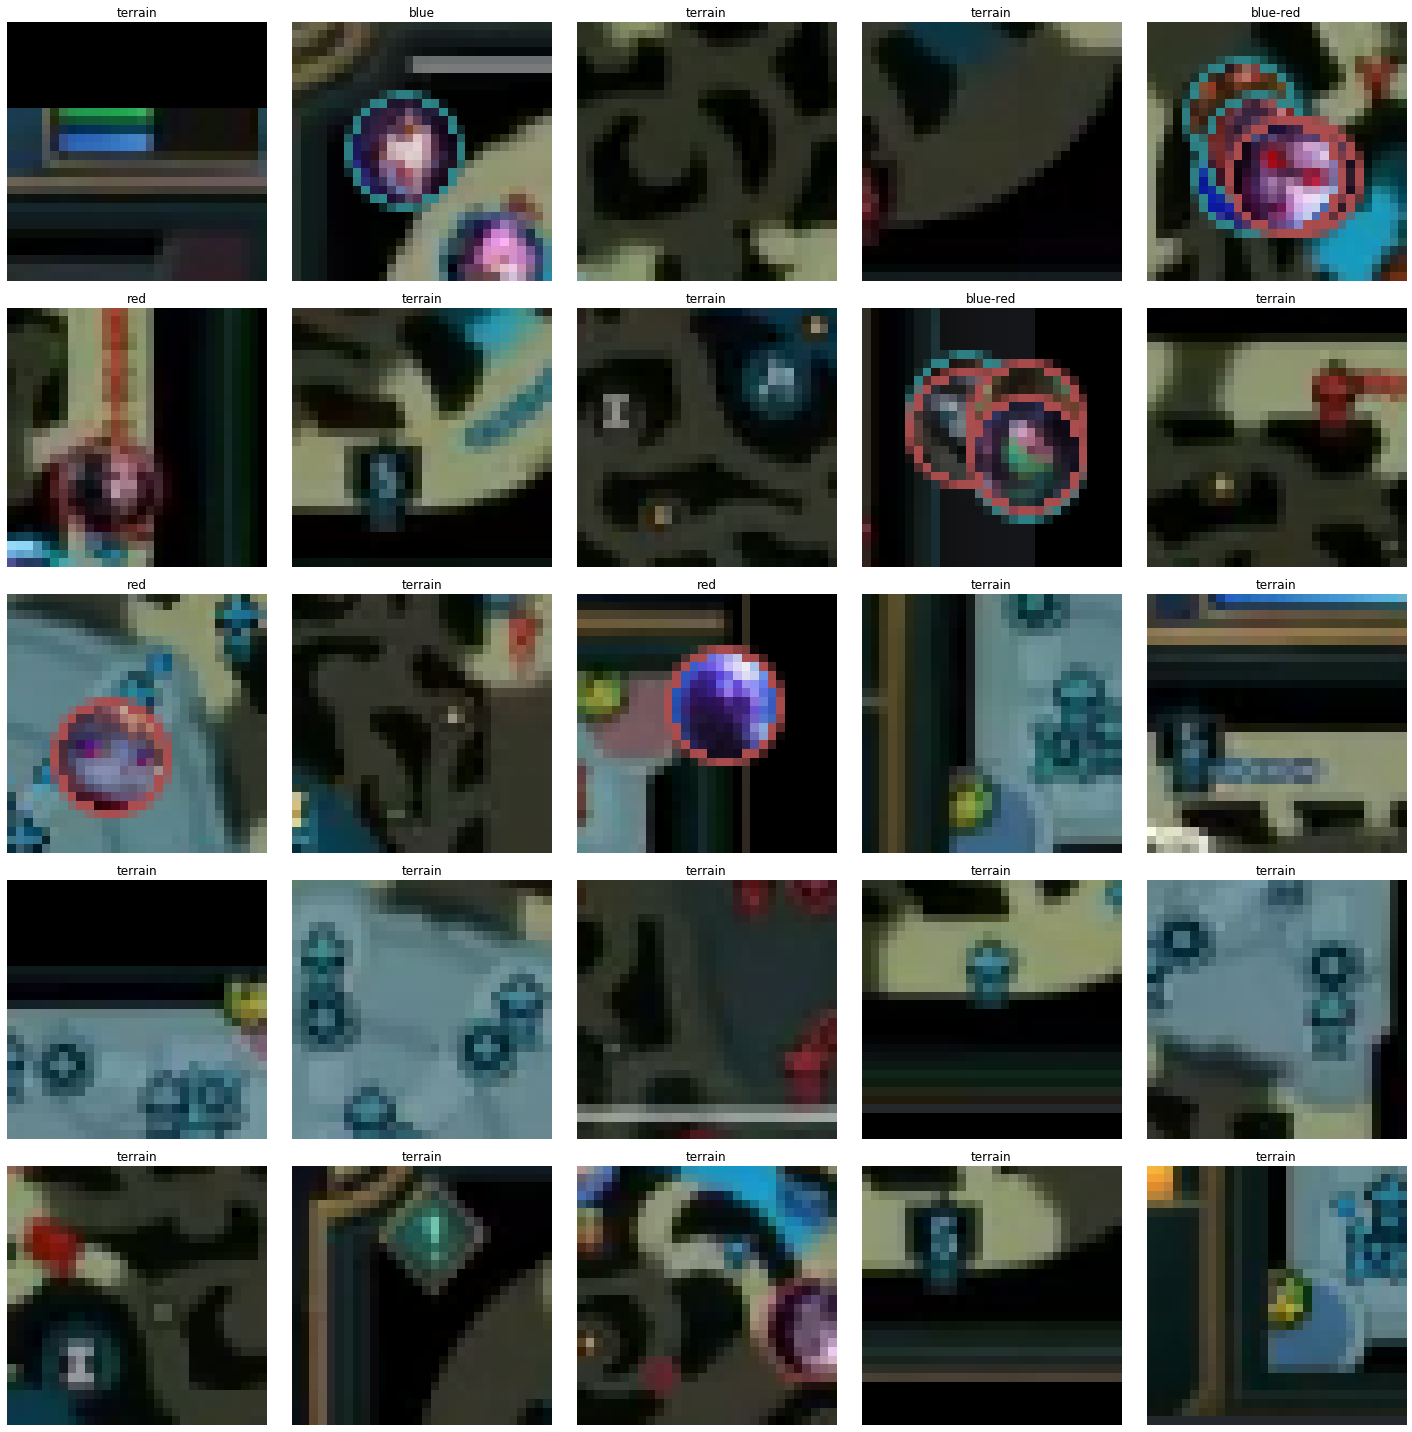

In [234]:
tfms = [[rand_zoom(p=1.0)], []]
data = ImageDataBunch.from_folder(
    data_dir+"/newdata", classes=["red", "blue", "blue-red", "terrain"], bs=256, ds_tfms=tfms)
data.show_batch()

# Train the Model

We train several models, and keep the one with the highest performance. It is still unknown why some models are better, but one explanation from the fastai course may be the initialization of parameters.

## Final Score Function

In [235]:
def get_score(learn):
    preds = learn.get_preds(DatasetType.Valid)[0]
    score = 0
    for i in range(len(learn.data.valid_dl.y)):
        if preds[i][0] > preds[i][1] and learn.data.valid_dl.y[i].data == 0:
            score += 1
        elif preds[i][0] < preds[i][1] and learn.data.valid_dl.y[i].data == 1:
            score += 1

    return score

## Model Training

In [236]:
best_learn = None
best_score = 0
lr = 0.02

for i in range(0, 1):
    learn = create_cnn(data, models.resnet101, metrics=[accuracy])
    gc.collect()
    learn.callbacks = [SaveModelCallback(
        learn, every='improvement', mode='min', name='best')]
    learn.fit_one_cycle(1, lr)
    learn.unfreeze()
    learn.fit_one_cycle(3, slice(1e-6, lr/5))

    new_score = get_score(learn)
    if new_score > best_score or not best_learn:
        best_learn = learn
        best_score = new_score
    print(f'Run {i} - Best Score: {best_score}')

epoch,train_loss,valid_loss,accuracy,time
0,0.110751,0.122096,0.954198,00:44


Better model found at epoch 0 with valid_loss value: 0.12209626287221909.


epoch,train_loss,valid_loss,accuracy,time
0,0.096063,0.144577,0.952256,00:57
1,0.070317,0.109837,0.962093,00:58
2,0.032875,0.117026,0.964223,00:57


Better model found at epoch 0 with valid_loss value: 0.14457665383815765.
Better model found at epoch 1 with valid_loss value: 0.10983655601739883.


Run 0 - Best Score: 2173


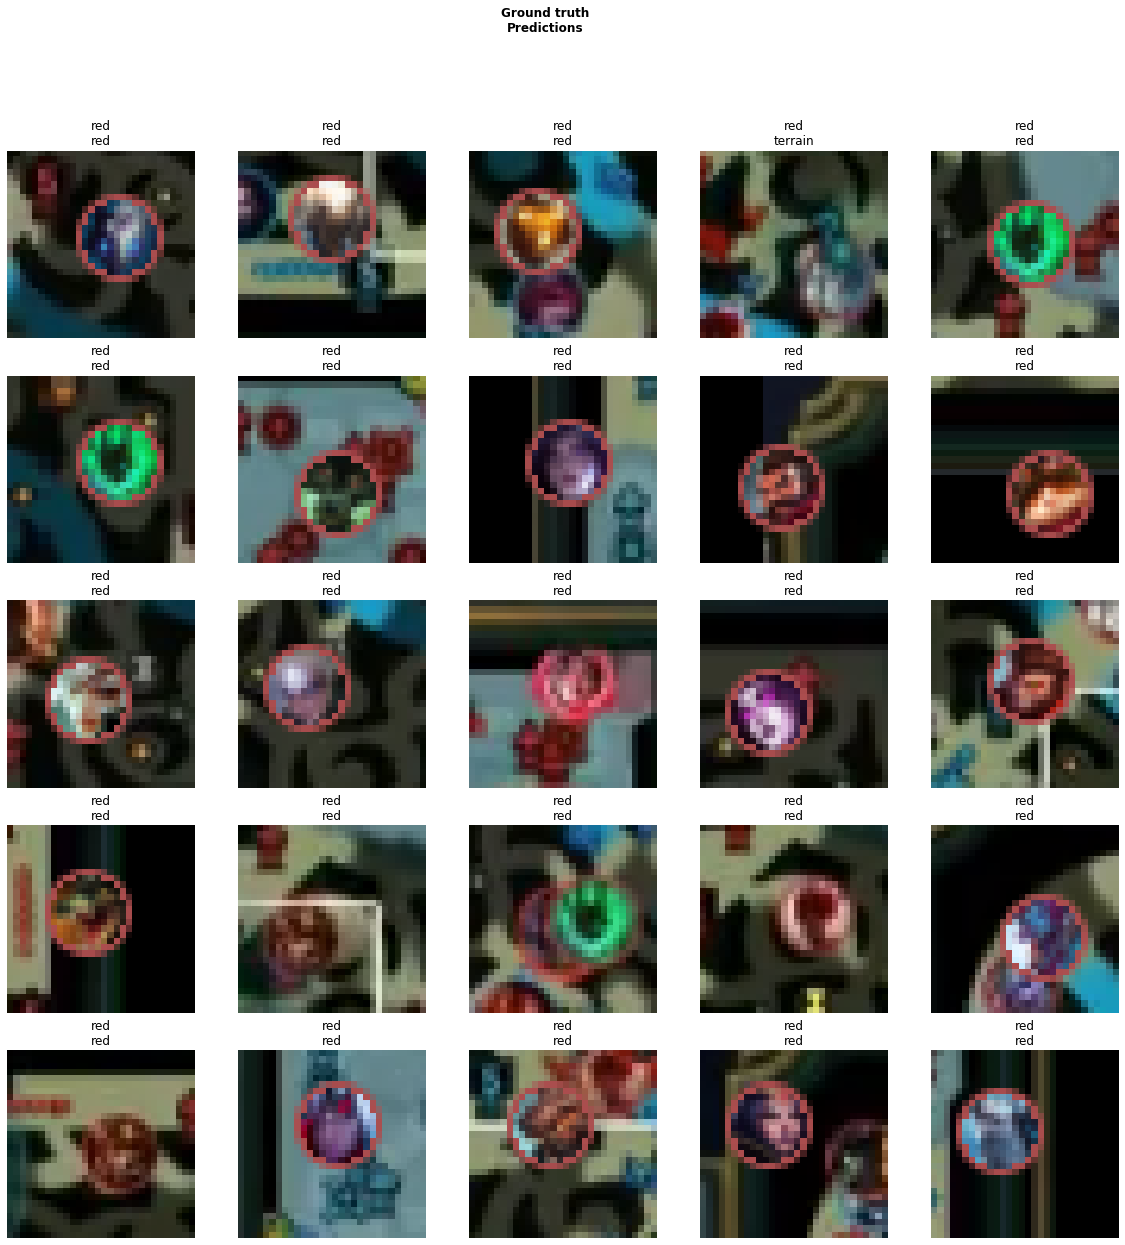

In [237]:
best_learn.show_results()

## Full Minimap Test

Display the model's predictions for an entire minimap.

In [243]:
grid_size = 10
prediction_threshold = 0.20


def empty_dir(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)


def draw_grid(draw, labels):
    fill = (0, 255, 255, 96)
    for l in labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        if l[2] == "red":
            fill = (255, 0, 0, 96)
        if l[2] == "blue":
            fill = (0, 0, 255, 96)
        if l[2] == "blue-red":
            fill = (0, 255, 0, 96)
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)


def draw_preds(filename, grids):
    img = PIL.Image.open(filename)

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, grids)
    out = PIL.Image.alpha_composite(img, overlay)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img);
    ax[1].imshow(out);
#     imshow(np.asarray(out))


def get_predictions(learner, predictions):
    # Predict the grid image types
    tmp_dir = data_dir + "/tmp"
    test = ImageList.from_folder(tmp_dir)
    learner.data.add_test(test)
    preds = learner.get_preds(ds_type=DatasetType.Test)
    num_preds = len(preds)
    z = 0

    # Identify the grids which are player squares
    for i in range(len(preds[0])):
        max_index = 0
        max_score = 0
        for p in range(len(preds[0][i])):
            if preds[0][i][p] > max_score:
                max_index = p
                max_score = preds[0][i][p]
                
        category = str(learn.data.classes[max_index])
        if category == "terrain":
            continue
        img = test.items[i]
        fname = img.stem
        num = int(fname.split("-")[1])
        name = fname.split("-")[0]
        x = num//1000
        y = num % 1000
        predictions[name].append((x, y, category))

    empty_dir(tmp_dir)
    return predictions


def get_grids(learner, filenames):
    print("locating player positions...")
    padding = 10
    num_files = len(filenames)
    predictions = {}
    # Split the image into grids and save the components to the tmp directory.
    tmp_dir = data_dir+"/tmp"
    empty_dir(tmp_dir)
    z = 0
    numfiles = len(filenames)
    for l in tqdm_notebook(range(numfiles)):
        f = filenames[l]
        if not ".png" in f:
            continue
        im = PIL.Image.open(f)
        imgwidth, imgheight = im.size
        base = os.path.basename(f)
        fname = os.path.splitext(base)[0]
        predictions[fname] = []
        for i in range(0, imgheight, grid_size):
            for j in range(0, imgwidth, grid_size):
                box = (j-padding, i-padding, j + grid_size +
                       padding, i + grid_size + padding)
                a = im.crop(box)
                a.save(data_dir+f"/tmp/{fname}-{j*1000//grid_size+i//10}.png")

        if z % 1000 == 0:
            predictions = get_predictions(learner, predictions)
        z += 1

    if len(os.listdir(tmp_dir)) > 0:
        predictions = get_predictions(learner, predictions)

    return predictions

In [ ]:
i = 300

['games/hka_lk_worlds_2019/full/hka_lk_worlds_2019_0000000327.png']
locating player positions...


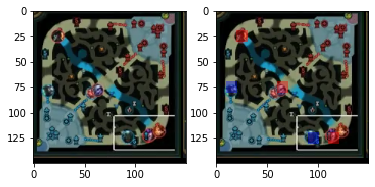

In [258]:
i += 3
s = str(i)
s = "0"*(3-len(s)) + s
filenames = [
    f"games/hka_lk_worlds_2019/full/hka_lk_worlds_2019_0000000{s}.png"]
print(filenames)
grids = get_grids(best_learn, filenames)
base = os.path.basename(filenames[0])
fname = os.path.splitext(base)[0]
draw_preds(filenames[0], grids[fname])
i += 1

## Loss Interpretation

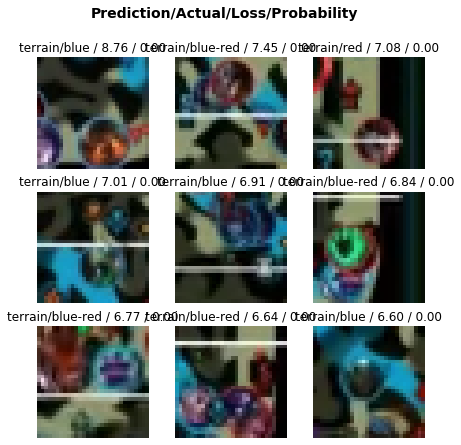

In [203]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(best_learn, preds, y, losses)
interp.plot_top_losses(9, figsize=(7, 7))

In [13]:
model_path = 'models/'
learn.export(model_path+"locator.pth")

# Collect Games Maps

Gather all the maps from each game into a single "full" folder and "team" folder. These two folders will be the source for training the final map prediction model.

In [204]:
collected_dir = "games_collected/"
games_dir = "games/"
empty_dir(collected_dir + "full")
empty_dir(collected_dir + "team")
empty_dir(collected_dir + "composite")

games = os.listdir(games_dir)
for g in games:
    if g == ".DS_Store":
        os.remove(games_dir+g)
        continue
    full_dir = games_dir + g + "/full/"
    full_images = os.listdir(full_dir)
    for img in full_images:
        if ".jpg" in img or ".png" in img:
            copyfile(full_dir + img, collected_dir + "full/" + img)

    team_dir = games_dir + g + "/team/"
    team_images = os.listdir(team_dir)
    for img in team_images:
        if ".jpg" in img or ".png" in img:
            copyfile(team_dir + img, collected_dir + "team/" + img)
            
    composite_dir = games_dir + g + "/composite/"
    composite_images = os.listdir(composite_dir)
    for img in composite_images:
        if ".jpg" in img or ".png" in img:
            copyfile(composite_dir + img, collected_dir + "composite/" + img)

print(f"Full images: {len(os.listdir(collected_dir + 'full'))}")
print(f"Team images: {len(os.listdir(collected_dir + 'team'))}")
print(f"Composite images: {len(os.listdir(collected_dir + 'composite'))}")

FileNotFoundError: [Errno 2] No such file or directory: 'games/ahq_ig_1_worlds_oct_12_2019/composite/'

In [30]:
# fulls = os.listdir(data_dir + 'full')
# teams = os.listdir(data_dir + 'team')
# for f in fulls:
#     if f not in teams:
#         print(f)
# shutil.rmtree(data_dir + 'full/models')

## Create Full Map Coordinates

Use the model we trained to predict the coordinates of each player in the maps. This csv will be used as the target in the final map prediction model.

In [4]:
data_dir = "./locator/"
tmp_dir = data_dir + "tmp"
collected_dir = "games_collected/"
empty_dir(tmp_dir)

In [118]:
fnames = []
tags = []
files = os.listdir(collected_dir + "full")

files = [f"{collected_dir}/full/{f}" for f in files]
grids = get_grids(best_learn, files)

for k, v in grids.items():
    v = [f"{g[0]}-{g[1]}" for g in v]
    v.sort()
    v = " ".join(v)
    fnames.append(k)
    tags.append(v)

df = pd.DataFrame({'image_name': fnames, 'tags': tags},
                  columns=['image_name', 'tags'])
convert_dict = {'image_name': str, 'tags': str}
df = df.astype(convert_dict)
df.replace('', np.nan, inplace=True) # Remove the mini-maps with no players.
df.dropna(subset=['tags'], inplace=True)
df.to_csv(collected_dir+"full_coordinates.csv", index=False)

locating player positions...


## Create Team Map Coordinates

Use the model we trained to predict the coordinates of each player in the team maps. This csv will be used to augment the data in the final prediction model.

In [20]:
fnames = []
tags = []
files = os.listdir(collected_dir + "team")

files = [f"{collected_dir}/team/{f}" for f in files]
grids = get_grids(best_learn, files)

for k, v in grids.items():
    v = [f"{g[0]}-{g[1]}" for g in v]
    v.sort()
    v = " ".join(v)
    fnames.append(k)
    tags.append(v)

df = pd.DataFrame({'image_name': fnames, 'tags': tags},
                  columns=['image_name', 'tags'])
convert_dict = {'image_name': str, 'tags': str}
df = df.astype(convert_dict)
df.replace('', np.nan, inplace=True) # Remove the mini-maps with no players.
df.dropna(subset=['tags'], inplace=True)
df.to_csv(collected_dir+"team_coordinates.csv", index=False)

locating player positions...


# Create Composite Maps

Merge a sequence of maps together to give the model an idea of where players are moving. We only need to merge the team mini-maps, the full mini-maps are only used to extract the coordinates of all player positions. The predictions are made on the player's maps.

## Composite Function

['10-9', '12-10', '12-11', '3-2', '3-3', '6-7', '7-6', '7-7', '8-5', '8-6', '9-4']
['11-11', '11-12', '12-10', '12-11', '12-12', '2-3', '3-2', '3-3', '7-5', '7-6', '7-7', '8-5', '8-6', '8-7']
['10-9', '11-11', '12-10', '12-11', '2-2', '2-3', '3-1', '3-2', '3-3', '8-4', '8-6', '8-7']
['11-12', '12-10', '12-11', '12-12', '2-2', '2-3', '3-2', '3-3', '8-4', '8-5', '8-7']
['11-11', '12-10', '12-11', '2-2', '2-3', '6-4', '7-4', '7-7', '8-6', '8-7']
['12-11', '12-12', '2-3', '3-3', '3-4', '7-4', '8-7', '8-8']
['12-11', '12-12', '3-3', '7-4', '8-7']
['12-10', '12-11', '12-12', '2-3', '2-4', '3-3', '3-4', '7-4', '7-7', '8-7']
['12-10', '12-11', '2-2', '2-3', '3-3', '6-7', '7-3', '7-4', '7-6', '7-7', '8-6']
['1-3', '11-11', '11-12', '12-10', '12-11', '12-12', '2-3', '2-4', '6-4', '7-4', '7-6', '7-7', '8-6']
['1-2', '1-3', '11-10', '11-11', '12-10', '12-11', '2-2', '2-3', '6-3', '6-4', '6-7', '7-3', '7-6', '7-7']
['12-10', '12-11', '12-12', '2-3', '2-4', '6-4', '7-3', '7-4', '7-6', '7-7', '8-6', 

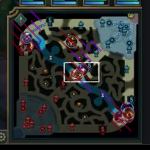

In [6]:
def create_composite(image_names, image_tags, game):
    image_names = [im.replace(".png", "") for im in image_names]
    img_path = f"games/{game}/team/{image_names[-1]}.png"
    img = PIL.Image.open(img_path)

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    
    for i in range(len(image_names)):
        grid = image_tags[image_names[i]].split(" ")
        print(grid)
        grid = [(int(g.split("-")[0]), int(g.split("-")[1])) for g in grid]
        
        c1 = int(255*((1+i)/16))
        c2 = 255 - c1
        alpha = 128
        fill = (128, 0, c2, alpha)
        for l in grid:
            x = l[0] * grid_size
            y = l[1] * grid_size
            draw.line([(x, y), (x+grid_size, y+grid_size)], fill=fill, width=2)
    
    out = PIL.Image.alpha_composite(img, overlay)
    return out

# Test create_composite
names = ['hka_isg_4_2019_0000000000', 'hka_isg_4_2019_0000000001', 'hka_isg_4_2019_0000000002', 'hka_isg_4_2019_0000000003', 'hka_isg_4_2019_0000000004', 'hka_isg_4_2019_0000000005', 'hka_isg_4_2019_0000000006', 'hka_isg_4_2019_0000000007',
         'hka_isg_4_2019_0000000008', 'hka_isg_4_2019_0000000009', 'hka_isg_4_2019_0000000010', 'hka_isg_4_2019_0000000011', 'hka_isg_4_2019_0000000012', 'hka_isg_4_2019_0000000013', 'hka_isg_4_2019_0000000014', 'hka_isg_4_2019_0000000015']


image_tags = {}
with open(collected_dir+"team_coordinates.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(reader)  # Skip the first line
    for row in reader:
        image_tags[row[0]] = row[1]
        
res = create_composite(names, image_tags, "hka_isg_4_2019")
display(res)

In [20]:
games_dir = "games/"
game_names = os.listdir(games_dir)
for game in tqdm_notebook(game_names):
    game_dir = f"{games_dir}{game}/team"
    composite_dir = f"{games_dir}{game}/composite"
    try:
        os.makedirs(composite_dir)
    except FileExistsError:
        pass
    
    images = os.listdir(game_dir)
    images.sort()
    for i in range(len(images)):
        if i >= 16 :
            img_paths = images[i-16:i]
        else:
            img_paths = [images[i]]*16
        try:
            res = create_composite(img_paths, image_tags, game)
            res.save(f"{composite_dir}/{images[i]}")
        except KeyError:
            print(images[i])

dfm_spy_worlds_2019_0000000708.png
dfm_spy_worlds_2019_0000000709.png
dfm_spy_worlds_2019_0000000710.png
dfm_spy_worlds_2019_0000000711.png
dfm_spy_worlds_2019_0000000712.png
dfm_spy_worlds_2019_0000000713.png
dfm_spy_worlds_2019_0000000714.png
dfm_spy_worlds_2019_0000000715.png
dfm_spy_worlds_2019_0000000716.png
dfm_spy_worlds_2019_0000000717.png
dfm_spy_worlds_2019_0000000718.png
dfm_spy_worlds_2019_0000000719.png
dfm_spy_worlds_2019_0000000720.png
dfm_spy_worlds_2019_0000000721.png
dfm_spy_worlds_2019_0000000722.png
dfm_spy_worlds_2019_0000000723.png
dfm_spy_worlds_2019_0000000724.png
dfm_spy_worlds_2019_0000000725.png
dfm_spy_worlds_2019_0000000726.png
lk_mg_worlds_2019_0000000914.png
lk_mg_worlds_2019_0000000915.png
lk_mg_worlds_2019_0000000916.png
lk_mg_worlds_2019_0000000917.png
lk_mg_worlds_2019_0000000918.png
lk_mg_worlds_2019_0000000919.png
lk_mg_worlds_2019_0000000920.png
lk_mg_worlds_2019_0000000921.png
lk_mg_worlds_2019_0000000922.png
lk_mg_worlds_2019_0000000923.png
lk_mg

## Collect Composite maps

In [21]:
games_dir = "games/"

empty_dir(collected_dir + "composite")
games = os.listdir(games_dir)
for g in games:
    if g == ".DS_Store":
        os.remove(games_dir+g)
        continue
            
    composite_dir = games_dir + g + "/composite/"
    composite_images = os.listdir(composite_dir)
    for img in composite_images:
        if ".jpg" in img or ".png" in img:
            copyfile(composite_dir + img, collected_dir + "composite/" + img)